# Probe geometry

PCA/probe-space visualizations (moved from `probe-statistics.ipynb`). Figures and parameters are unchanged; cells below load the same artifacts and plot the projections.

Note: if probes were trained with PCA preprocessing, embeddings are projected to the first N components before applying the probe weights.


In [2]:
# Parameters
from pathlib import Path

NORMALIZE = False  # set True to load normalized-distance results
DEPTH_RANGE = [1, 2]
STEPS_RANGE = [1, 2]
NUM_SAMPLES = 1000

def _parse_range(values, name: str, min_value: int = 1) -> tuple[int, int]:
    if isinstance(values, (int, float)):
        values = [int(values)]
    if len(values) == 1:
        range_min = range_max = int(values[0])
    elif len(values) == 2:
        range_min, range_max = [int(v) for v in values]
    else:
        raise ValueError(f"{name} must have 1 or 2 integers")
    if range_min < min_value or range_max < min_value or range_max < range_min:
        raise ValueError(f"{name} must be >= {min_value} and max >= min")
    return range_min, range_max


def _format_steps_tag(num_steps) -> str:
    if isinstance(num_steps, (list, tuple)):
        if len(num_steps) != 2:
            raise ValueError("num_steps must have 1 or 2 integers")
        min_steps, max_steps = num_steps
    else:
        min_steps = max_steps = int(num_steps)
    if min_steps == max_steps == 1:
        return ""
    if min_steps == max_steps:
        return f"_steps{min_steps}"
    return f"_steps{min_steps}-{max_steps}"


def _dataset_tag(min_depth: int, max_depth: int, num_samples: int, num_steps) -> str:
    suffix = f"n{num_samples}" if num_samples > 0 else "nall"
    steps = _format_steps_tag(num_steps)
    return f"depth{min_depth}-{max_depth}_{suffix}{steps}"


MIN_DEPTH, MAX_DEPTH = _parse_range(DEPTH_RANGE, "depth-range", min_value=1)
MIN_STEPS, MAX_STEPS = _parse_range(STEPS_RANGE, "steps-range", min_value=1)
STEPS_TAG = (MIN_STEPS, MAX_STEPS) if MIN_STEPS != MAX_STEPS else MIN_STEPS
DATASET_TAG = _dataset_tag(MIN_DEPTH, MAX_DEPTH, NUM_SAMPLES, STEPS_TAG)
MODEL_TAG = "DeepSeek-R1-Distill-Qwen-14B"
PROJ_DIM = 5
PCA_COMPONENTS = 10
PCA_TRAIN_SPLIT = 0.5
PCA_SEED = 0
COLORCODE = "depth"  # options: "depth" or "subtree" or "order"
LAYER = 31  # Layer to use for per-example stats, true vs predicted, and tree reconstruction plots
DEPTH_FILTER = 2
MIN_PATH_LEN = 8

norm_suffix = "_normtree" if NORMALIZE else ""
RESULTS_PATH = Path(f"../data/{DATASET_TAG}/models/{MODEL_TAG}/probes/probe{norm_suffix}_proj{PROJ_DIM}_pca{PCA_COMPONENTS}.npz")

In [3]:
import json
import sys
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize
from matplotlib import patheffects

NOTEBOOK_DIR = Path.cwd().resolve()
for candidate in [NOTEBOOK_DIR, *NOTEBOOK_DIR.parents]:
    if (candidate / "cutter").exists():
        PROJECT_ROOT = candidate
        break
else:
    raise RuntimeError("Could not locate repository root containing cutter/")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from cutter.utils.tree.probing import pairwise_distance, transform_probe_space, fit_depth_probe

sns.set_theme(style="whitegrid")
SPLIT_PALETTE = {
    "train": "#1f77b4",
    "test": "#d62728",
    "test_exact": "#2ca02c",
    "test_inexact": "#ff7f0e",
}

if not RESULTS_PATH.exists():
    raise FileNotFoundError(f"Probe results not found: {RESULTS_PATH}")

artifact = np.load(RESULTS_PATH, allow_pickle=True)
meta = artifact["meta"].item()
encodings = artifact["encodings"].item()
results = artifact["results"].item()

def _pca_transform(features: np.ndarray, res: dict) -> np.ndarray:
    pca = res.get("pca") if isinstance(res, dict) else None
    if not pca:
        return features
    components = np.asarray(pca.get("components", []), dtype=np.float32)
    mean = np.asarray(pca.get("mean", 0.0), dtype=np.float32)
    if components.size == 0:
        return features
    if features.shape[1] == components.shape[0]:
        return features
    return (features - mean) @ components.T


def _resolve_probe_projection(res: dict) -> np.ndarray:
    if isinstance(res, dict) and isinstance(res.get("distance"), dict) and res["distance"].get("projection") is not None:
        return res["distance"]["projection"]
    if isinstance(res, dict) and res.get("projection") is not None:
        return res["projection"]
    raise ValueError("No projection found in results for the requested layer.")



def _project_to_2d(Z: np.ndarray) -> np.ndarray:
    if Z.ndim != 2:
        raise ValueError(f"Expected 2D array for projection, got shape {Z.shape}")
    if Z.shape[1] <= 2:
        return Z
    if Z.shape[0] == 0:
        return Z[:, :2]
    Z_centered = Z - Z.mean(axis=0, keepdims=True)
    _, _, vt = np.linalg.svd(Z_centered, full_matrices=False)
    components = vt[:2]
    return Z_centered @ components.T

print("Loaded artifact with layers:", list(results.keys()))

Loaded artifact with layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [4]:
# Rebuild layer encodings (X/dist) if saved artifact is lightweight
from cutter.scripts.evaluate_probe import load_embedding_cache
from cutter.utils.tree.trees import tree_distance
from cutter.utils.shared.embeddings_cache import ensure_pca_cache
from cutter.utils.shared.paths import embeddings_path as default_embeddings_path


def _locate_embeddings(meta: dict, results_path: Path, project_root: Path) -> Path:
    meta_path = meta.get("embeddings_path")
    if meta_path:
        p = Path(meta_path)
        if p.exists():
            return p
        if not p.is_absolute():
            p = project_root / p
            if p.exists():
                return p

    dataset_tag = meta.get("dataset_tag")
    model_id = meta.get("model")
    if dataset_tag and model_id and PCA_COMPONENTS >= 0:
        try:
            pca_components = int(meta.get("pca_components", PCA_COMPONENTS))
            train_split = float(meta.get("pca_train_split", PCA_TRAIN_SPLIT))
            seed = int(meta.get("pca_seed", PCA_SEED))
            split_type = str(meta.get("pca_split_type", "exact-only"))
            pca_path = ensure_pca_cache(
                dataset_tag,
                model_id,
                pca_components,
                train_split,
                seed,
                split_type,
            )
            if pca_path is not None and Path(pca_path).exists():
                return Path(pca_path)
        except Exception:
            pass

    # probe path: ../models/<model>/probes/probe_*.npz -> sibling embeddings.npz
    candidates = [results_path.parent.parent / "embeddings.npz"]
    if dataset_tag and model_id:
        try:
            candidates.append(default_embeddings_path(dataset_tag, model_id))
        except Exception:
            pass
    for cand in candidates:
        if cand and Path(cand).exists():
            return Path(cand)
    return Path()


def _rebuild_layer_encoding(layer: int, data: dict, meta: dict, results_path: Path, project_root: Path) -> dict:
    """Rebuild X and dist for a single layer only."""
    # If already has X/dist, return as-is
    if isinstance(data, dict) and "X" in data and "dist" in data:
        return data
    
    emb_path = _locate_embeddings(meta, results_path, project_root)
    cache = load_embedding_cache(emb_path) if emb_path.exists() else None
    if cache is None:
        raise RuntimeError(f"Cannot rebuild encodings without embeddings cache. Tried: {emb_path}")
    
    example_ids = np.asarray(data.get("example_ids", []), dtype=int)
    node_ids = np.asarray(data.get("node_ids", []), dtype=int)
    depths = np.asarray(data.get("depth", []), dtype=float)
    blocks = []
    idx = 0
    # Reconstitute X by grouping contiguous rows per example id.
    while idx < len(example_ids):
        ex_id = int(example_ids[idx])
        count = 1
        while idx + count < len(example_ids) and example_ids[idx + count] == ex_id:
            count += 1
        rec = cache.get(ex_id)
        if rec is None:
            raise KeyError(f"Missing embedding cache entry for example {ex_id}")
        emb_layer = rec.get("embeddings_by_layer", {}).get(layer) if isinstance(rec, dict) else getattr(rec, "embeddings_by_layer", {}).get(layer)
        if emb_layer is None:
            raise KeyError(f"No embeddings for layer {layer} in example {ex_id}")
        block = np.asarray(emb_layer, dtype=np.float32)[:count]
        if block.shape[0] != count:
            raise ValueError(f"Embedding rows {block.shape[0]} do not match expected count {count} for example {ex_id}")
        blocks.append(block)
        idx += count
    X = np.vstack(blocks) if blocks else np.empty((0, 0), dtype=np.float32)
    n = len(node_ids)
    dist = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(i + 1, n):
            dist[i, j] = dist[j, i] = float(tree_distance(int(node_ids[i]), int(node_ids[j])))
    return {**data, "X": X, "dist": dist}


# Only rebuild the specified layer if it's missing X or dist
layer_data = encodings.get(LAYER, {})
needs_rebuild = not (isinstance(layer_data, dict) and "X" in layer_data and "dist" in layer_data)
if needs_rebuild:
    encodings[LAYER] = _rebuild_layer_encoding(LAYER, layer_data, meta, RESULTS_PATH, PROJECT_ROOT)
    print(f"Rebuilt encodings for layer {LAYER} from embeddings cache.")
else:
    print(f"Layer {LAYER} already contains X/dist; skipping rebuild.")

Rebuilt encodings for layer 31 from embeddings cache.


In [5]:
# Color helpers for tree projections
RESPONSES_PATH = RESULTS_PATH.parent.parent / "responses.jsonl"

# Load exact_match mapping from responses.jsonl
exact_match_map = {}
if RESPONSES_PATH and Path(RESPONSES_PATH).exists():
    with open(RESPONSES_PATH) as f:
        for line in f:
            rec = json.loads(line)
            ex_id = rec.get("example_id")
            if ex_id is not None:
                exact_match_map[ex_id] = rec.get("exact_match", False)

SUBTREE_CMAP = ListedColormap(["#1f77b4", "#d62728", "#7f7f7f"])
SUBTREE_BOUNDARIES = [-0.5, 0.5, 1.5, 2.5]
SUBTREE_TICKS = [0, 1, 2]
SUBTREE_LABELS = ["Left", "Right", "Root"]

def _root_child_label(node_id: int) -> str:
    if node_id == 0:
        return "root"
    child = node_id
    parent = (child - 1) // 2
    while parent > 0:
        child = parent
        parent = (parent - 1) // 2
    return "left" if child == 1 else "right"

def _parse_path_tokens(text) -> list[int]:
    tokens = str(text).replace(",", " ").split()
    parsed = []
    for tok in tokens:
        try:
            parsed.append(int(tok))
        except Exception:
            continue
    return parsed

def _load_path_orders(responses_path: Path):
    lookup = {}
    max_len = 0
    if responses_path and Path(responses_path).exists():
        with open(responses_path) as f:
            for line in f:
                rec = json.loads(line)
                ex_id = rec.get("example_id")
                if ex_id is None:
                    continue
                seq = rec.get("parsed_path") or rec.get("path")
                if isinstance(seq, str):
                    seq = _parse_path_tokens(seq)
                elif not seq:
                    txt = rec.get("parsed_text")
                    seq = _parse_path_tokens(txt) if txt else []
                if not seq:
                    txt = rec.get("parsed_text")
                    if txt:
                        seq = _parse_path_tokens(txt)
                if not seq:
                    continue
                orders = {int(node_id): idx for idx, node_id in enumerate(seq)}
                lookup[int(ex_id)] = orders
                max_len = max(max_len, len(seq))
    return lookup, max_len

PATH_ORDER_LOOKUP, MAX_PATH_LEN = _load_path_orders(RESPONSES_PATH)

def _order_cmap(n_orders: int) -> ListedColormap:
    if n_orders <= 0:
        return ListedColormap(np.array([[0.7, 0.7, 0.7, 1.0]]))
    grad = plt.get_cmap("plasma")(np.linspace(0.15, 0.85, n_orders))
    colors = np.vstack(([0.7, 0.7, 0.7, 1.0], grad))
    return ListedColormap(colors)

def prepare_colorcode(colorcode: str, node_ids: np.ndarray, depths: np.ndarray, example_ids: np.ndarray):
    code = (colorcode or "depth").lower()
    if code == "subtree":
        labels = np.array([_root_child_label(int(nid)) for nid in node_ids])
        mapping = {"left": 0, "right": 1, "root": 2}
        values = np.array([mapping[label] for label in labels], dtype=float)
        # Discrete, high-contrast subtree colors
        cmap = SUBTREE_CMAP
        norm = BoundaryNorm(SUBTREE_BOUNDARIES, cmap.N)
        cbar_label = "Subtree"
        tick_locs = SUBTREE_TICKS
        tick_labels = SUBTREE_LABELS
    elif code == "order":
        example_ids = np.asarray(example_ids)
        node_ids_arr = np.asarray(node_ids)
        if example_ids.size != node_ids_arr.size:
            raise ValueError("example_ids and node_ids must align for order color coding")
        values = np.array([
            PATH_ORDER_LOOKUP.get(int(ex_id), {}).get(int(nid), -1)
            for ex_id, nid in zip(example_ids, node_ids_arr)
        ], dtype=float)
        n_orders = max(MAX_PATH_LEN, int(values[values >= 0].max()) + 1 if np.any(values >= 0) else 0)
        # Discrete bins for {-1, 0, ..., n_orders-1}
        cmap = _order_cmap(n_orders)
        boundaries = np.arange(-1.5, n_orders + 0.5, 1.0)
        norm = BoundaryNorm(boundaries, cmap.N)
        cbar_label = "Path order"
        tick_locs = [-1] + list(range(n_orders))
        tick_labels = ["Not in path"] + [str(i) for i in range(n_orders)]
    else:
        # Discretize depth into integer bins for a stepped colorbar
        values = np.asarray(depths)
        cbar_label = "Depth"
        if values.size:
            dmin = int(values.min())
            dmax = int(values.max())
            boundaries = np.arange(dmin - 0.5, dmax + 1.5, 1.0)
            cmap = plt.get_cmap("Blues", dmax - dmin + 1)
            norm = BoundaryNorm(boundaries, cmap.N)
            tick_locs = list(range(dmin, dmax + 1))
            tick_labels = [str(d) for d in tick_locs]
        else:
            cmap = "Blues"
            norm = None
            tick_locs = tick_labels = None

    return values, cmap, norm, cbar_label, tick_locs, tick_labels

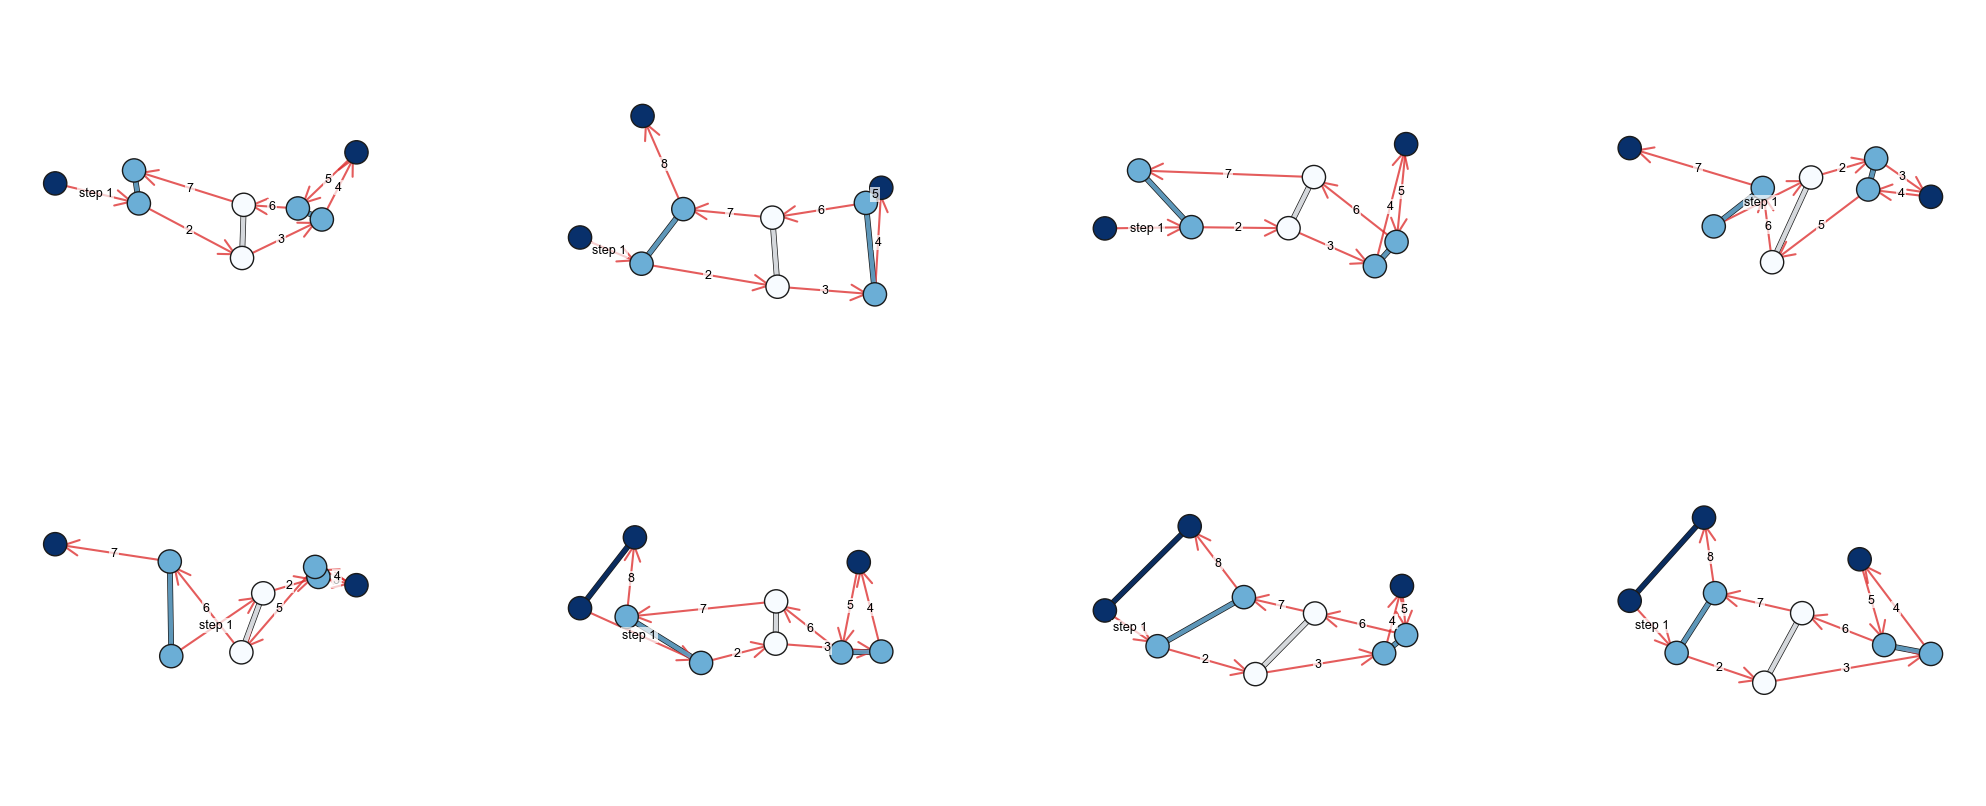

In [9]:
# Per-example projected embeddings (2x4 grid)
from pathlib import Path
import json

GRID_ROWS = 2
GRID_COLS = 4
GRID_EXAMPLES = GRID_ROWS * GRID_COLS

EMBEDDINGS_PATH = _locate_embeddings(meta, RESULTS_PATH, PROJECT_ROOT)
RESPONSES_PATH = PROJECT_ROOT / f"cutter/data/{DATASET_TAG}/models/{MODEL_TAG}/responses.jsonl"

if not EMBEDDINGS_PATH.exists():
    raise FileNotFoundError(f"Embeddings cache not found: {EMBEDDINGS_PATH}")

embedding_records = np.load(EMBEDDINGS_PATH, allow_pickle=True)["embeddings"]


def project_embeddings(arr: np.ndarray, B: np.ndarray, geometry: str, info: Dict[str, Any], res: dict) -> np.ndarray:
    features = _pca_transform(arr.astype(np.float32), res)
    proj = features @ B
    if geometry == "hyperbolic":
        proj = transform_probe_space(proj, info)
    return proj


def collect_test_exact_ids(layer: int, depth_filter: int = DEPTH_FILTER, min_path_len: int = MIN_PATH_LEN):
    data = encodings[layer]
    example_ids = np.asarray(data.get("example_ids", []))
    if example_ids.size == 0:
        raise ValueError("Encodings missing example_ids; cannot map to embeddings")
    train_idx = set(data.get("train_idx", []))
    splits = np.array(["train" if i in train_idx else "test" for i in range(len(example_ids))])
    per_example_split = {}
    for idx, ex_id in enumerate(example_ids):
        per_example_split.setdefault(ex_id, splits[idx])
    test_ids = {ex for ex, sp in per_example_split.items() if sp == "test"}

    exact_ids = set()
    depth_ok = set()
    path_len_ok = set()
    with open(RESPONSES_PATH) as f:
        for line in f:
            rec = json.loads(line)
            ex_id = rec.get("example_id")
            if rec.get("depth") == depth_filter:
                depth_ok.add(ex_id)
            if rec.get("exact_match"):
                exact_ids.add(ex_id)
            parsed_path = rec.get("parsed_path") or rec.get("path")
            if parsed_path and len(parsed_path) >= min_path_len:
                path_len_ok.add(ex_id)

    available_ids = {rec["example_id"] for rec in embedding_records}
    candidates = sorted(test_ids & exact_ids & available_ids & depth_ok & path_len_ok)
    if not candidates:
        raise ValueError("No overlapping test_exact examples between encodings, responses, and embeddings.npz after filters")
    return candidates


def _max_tree_depth(responses_path: Path) -> int:
    max_depth = 1
    if responses_path and responses_path.exists():
        with open(responses_path) as f:
            for line in f:
                rec = json.loads(line)
                depth = rec.get("depth")
                if isinstance(depth, (int, float)):
                    max_depth = max(max_depth, int(depth))
    return max_depth


def _load_path_info(example_id: int):
    label_mapping = []
    parsed_path = []
    with open(RESPONSES_PATH) as f:
        for line in f:
            rec = json.loads(line)
            if rec.get("example_id") == example_id:
                label_mapping = rec.get("label_mapping") or []
                parsed_path = rec.get("parsed_path") or []
                break
    return label_mapping, parsed_path


def _example_distance_mse(example_id: int, layer: int, normalize_tree: bool, normalization_factor: float | None) -> float:
    data = encodings[layer]
    res = results[layer]
    X = data["X"]
    example_ids = np.asarray(data.get("example_ids", []))
    node_ids = np.asarray(data.get("node_ids", []))
    mask_example = example_ids == example_id
    X_example = _pca_transform(np.asarray(X[mask_example]), res)
    node_ids_example = node_ids[mask_example]

    B = _resolve_probe_projection(res)
    info = {
        "geometry": res.get("geometry", meta.get("fit_geometry", "euclidean")),
        "center": res.get("center"),
        "curvature": res.get("curvature"),
        "normalized_tree": res.get("normalized_tree", meta.get("normalize_tree", False)),
    }
    geometry = info.get("geometry", meta.get("fit_geometry", "euclidean"))

    Z_example = X_example @ B
    pred_dist = pairwise_distance(Z_example, geometry, center=info.get("center"), curvature=info.get("curvature"))

    n = len(node_ids_example)
    true_dist = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(i + 1, n):
            true_dist[i, j] = true_dist[j, i] = float(tree_distance(int(node_ids_example[i]), int(node_ids_example[j])))

    if normalize_tree and normalization_factor:
        true_dist = true_dist / normalization_factor
        pred_dist = pred_dist / normalization_factor

    tri = np.triu(np.ones_like(true_dist, dtype=bool), k=1)
    diff = true_dist[tri] - pred_dist[tri]
    return float(np.mean(diff ** 2))


def plot_example_projection(ax, layer: int, example_id: int, label_mapping: list[int] | None = None, parsed_path: list[int] | None = None):
    data = encodings[layer]
    res = results[layer]
    X = data["X"]
    depths = data["depth"]
    example_ids = np.asarray(data.get("example_ids", []))
    node_ids = np.asarray(data.get("node_ids", []))
    label_mapping = label_mapping or []
    inverse_label = {int(label): idx for idx, label in enumerate(label_mapping)} if label_mapping else {}
    color_values, cmap, norm, _, _, _ = prepare_colorcode(COLORCODE, node_ids, depths, example_ids)
    B = _resolve_probe_projection(res)
    info = {
        "geometry": res.get("geometry", meta.get("fit_geometry", "euclidean")),
        "center": res.get("center"),
        "curvature": res.get("curvature"),
        "normalized_tree": res.get("normalized_tree", meta.get("normalize_tree", False)),
    }
    geometry = info.get("geometry", meta.get("fit_geometry", "euclidean"))

    Z = project_embeddings(X, B, geometry, info, res)
    Z = _project_to_2d(Z)

    mask_example = example_ids == example_id
    Z_example = Z[mask_example]
    depths_example = depths[mask_example]
    colors_example = color_values[mask_example]
    node_ids_example = node_ids[mask_example]

    path_node_ids = []
    if parsed_path:
        for tok in parsed_path:
            try:
                label_val = int(tok)
                canonical_id = inverse_label.get(label_val, label_val)
                path_node_ids.append(int(canonical_id))
            except Exception:
                continue

    path_indices = []
    if path_node_ids:
        path_node_ids = [int(nid) for nid in path_node_ids]
        node_ids_list = [int(nid) for nid in node_ids_example]
        if node_ids_list[: len(path_node_ids)] == path_node_ids:
            path_indices = list(range(len(path_node_ids)))
        else:
            ptr = 0
            for idx, nid in enumerate(node_ids_list):
                if ptr < len(path_node_ids) and nid == path_node_ids[ptr]:
                    path_indices.append(idx)
                    ptr += 1

    # Rotate embeddings to make depth levels as horizontally level as possible
    overall_center = Z_example.mean(axis=0)
    centered = Z_example - overall_center
    unique_depths = np.unique(depths_example)

    def _leveling_cost(theta: float) -> float:
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        R = np.array([[cos_t, -sin_t], [sin_t, cos_t]])
        rotated = centered @ R.T
        cost = 0.0
        for d in unique_depths:
            mask = depths_example == d
            if mask.any():
                y = rotated[mask, 1]
                y_mean = float(y.mean())
                diff = y - y_mean
                cost += float((diff * diff).sum())
        return cost

    # Coarse grid search over [-pi/2, pi/2] (rotation only)
    angles = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 361)
    costs = np.array([_leveling_cost(theta) for theta in angles])
    best_theta = float(angles[int(costs.argmin())])

    cos_a, sin_a = np.cos(best_theta), np.sin(best_theta)
    R = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    Z_example = centered @ R.T + overall_center

    # Invert y-axis so lowest-depth nodes end up near the top
    Z_example[:, 1] = 2 * overall_center[1] - Z_example[:, 1]

    # Connect multiple embeddings of the same node with a clearer line
    for node_id in np.unique(node_ids_example):
        idxs = np.where(node_ids_example == node_id)[0]
        if idxs.size > 1:
            coords = Z_example[idxs]
            line_color = cmap(norm(colors_example[idxs[0]]))
            ax.plot(
                coords[:, 0],
                coords[:, 1],
                linestyle="-",
                color="black",
                alpha=0.9,
                lw=4.2,
                zorder=0,
            )
            ax.plot(
                coords[:, 0],
                coords[:, 1],
                linestyle="-",
                color=line_color,
                alpha=0.85,
                lw=3.2,
                zorder=1,
            )

    if path_node_ids and len(path_indices) > 1:
        x_range = Z_example[:, 0].max() - Z_example[:, 0].min()
        y_range = Z_example[:, 1].max() - Z_example[:, 1].min()
        avg_range = (x_range + y_range) / 2
        node_radius_estimate = avg_range * 0.02
        arrow_color = "#dc2626"

        for i in range(len(path_indices) - 1):
            idx1, idx2 = path_indices[i], path_indices[i + 1]
            x1, y1 = Z_example[idx1, 0], Z_example[idx1, 1]
            x2, y2 = Z_example[idx2, 0], Z_example[idx2, 1]

            dx = x2 - x1
            dy = y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            if dist > 0:
                shrink_factor = 1.0 - (node_radius_estimate * 0.7) / dist
                x2_adj = x1 + dx * shrink_factor
                y2_adj = y1 + dy * shrink_factor
            else:
                x2_adj, y2_adj = x2, y2

            ax.annotate("", xy=(x2_adj, y2_adj), xytext=(x1, y1),
                        arrowprops=dict(arrowstyle="->", color=arrow_color, lw=1.5, alpha=0.75,
                                        mutation_scale=28),
                        zorder=0)
            label_x = (x1 + x2_adj) / 2
            label_y = (y1 + y2_adj) / 2
            step_label = "step 1" if i == 0 else f"{i + 1}"
            ax.text(
                label_x,
                label_y,
                step_label,
                color="black",
                fontsize=9,
                ha="center",
                va="center",
                zorder=2,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.0),
            )

    ax.scatter(
        Z_example[:, 0],
        Z_example[:, 1],
        c=colors_example,
        cmap=cmap,
        norm=norm,
        edgecolors="k",
        s=280,
        marker="o",
        zorder=1
    )

    x_min, x_max = Z_example[:, 0].min(), Z_example[:, 0].max()
    y_min, y_max = Z_example[:, 1].min(), Z_example[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    padding = max_range * 0.15
    ax.set_xlim(x_center - max_range / 2 - padding, x_center + max_range / 2 + padding)
    ax.set_ylim(y_center - max_range / 2 - padding, y_center + max_range / 2 + padding)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_aspect("equal", adjustable="box")


candidates = collect_test_exact_ids(LAYER, depth_filter=DEPTH_FILTER, min_path_len=MIN_PATH_LEN)
normalization_factor = _max_tree_depth(RESPONSES_PATH) if meta.get("normalize_tree") else None
ranked = sorted(
    candidates,
    key=lambda ex_id: _example_distance_mse(ex_id, LAYER, bool(meta.get("normalize_tree")), normalization_factor),
)
chosen = ranked[: min(GRID_EXAMPLES, len(ranked))]

fig, axes = plt.subplots(GRID_ROWS, GRID_COLS, figsize=(22, 8))
axes = np.ravel(axes)
for ax, ex_id in zip(axes, chosen):
    label_mapping, parsed_path = _load_path_info(ex_id)
    plot_example_projection(ax, LAYER, ex_id, label_mapping, parsed_path)

for ax in axes[len(chosen):]:
    ax.axis("off")

fig.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.2)

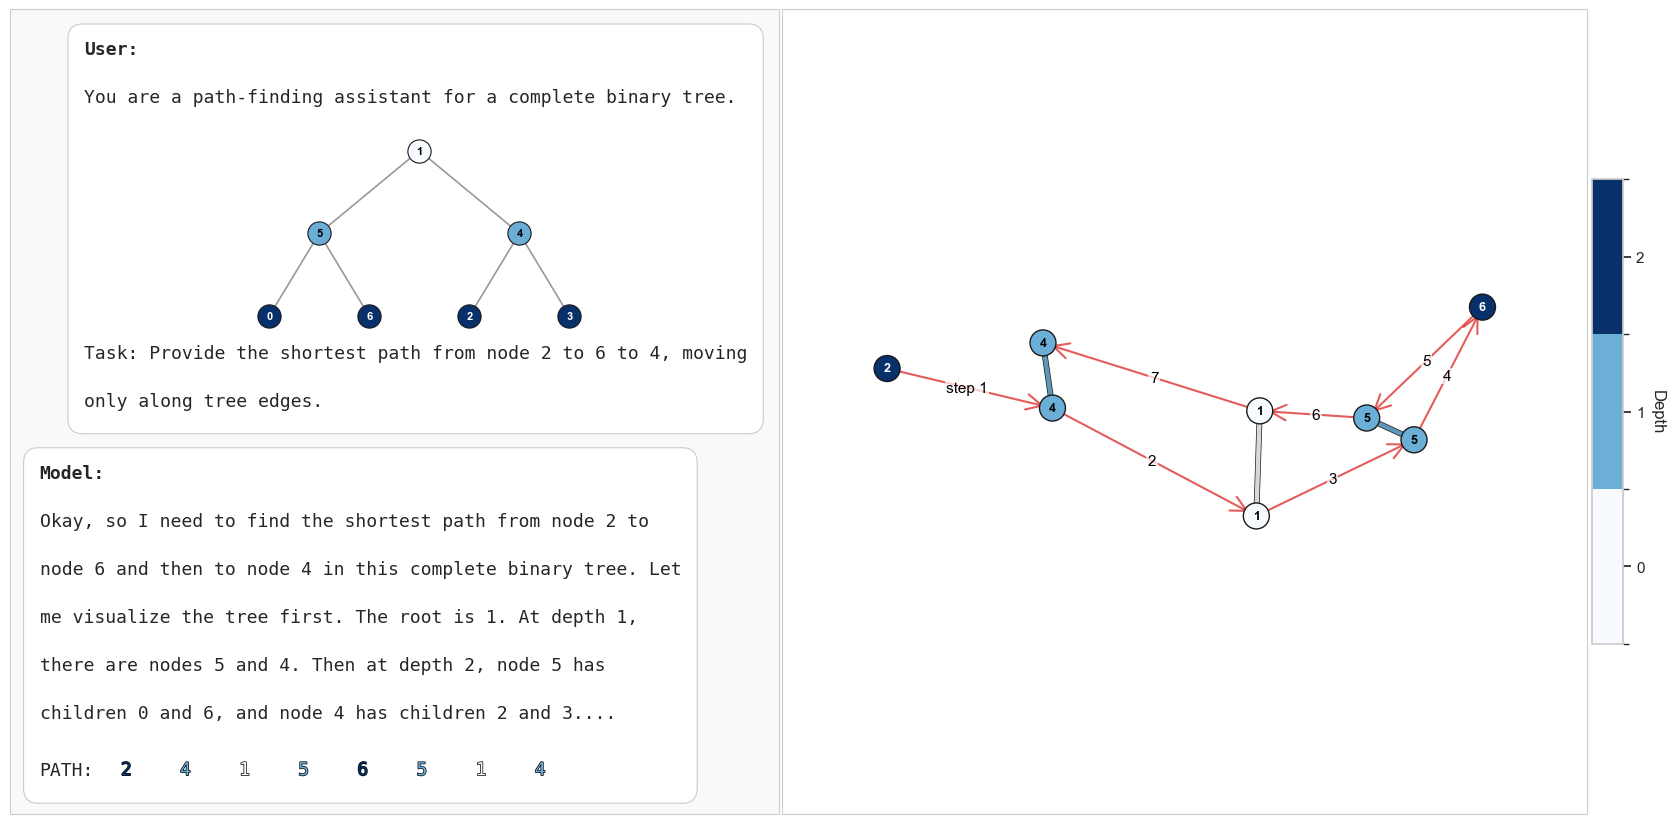

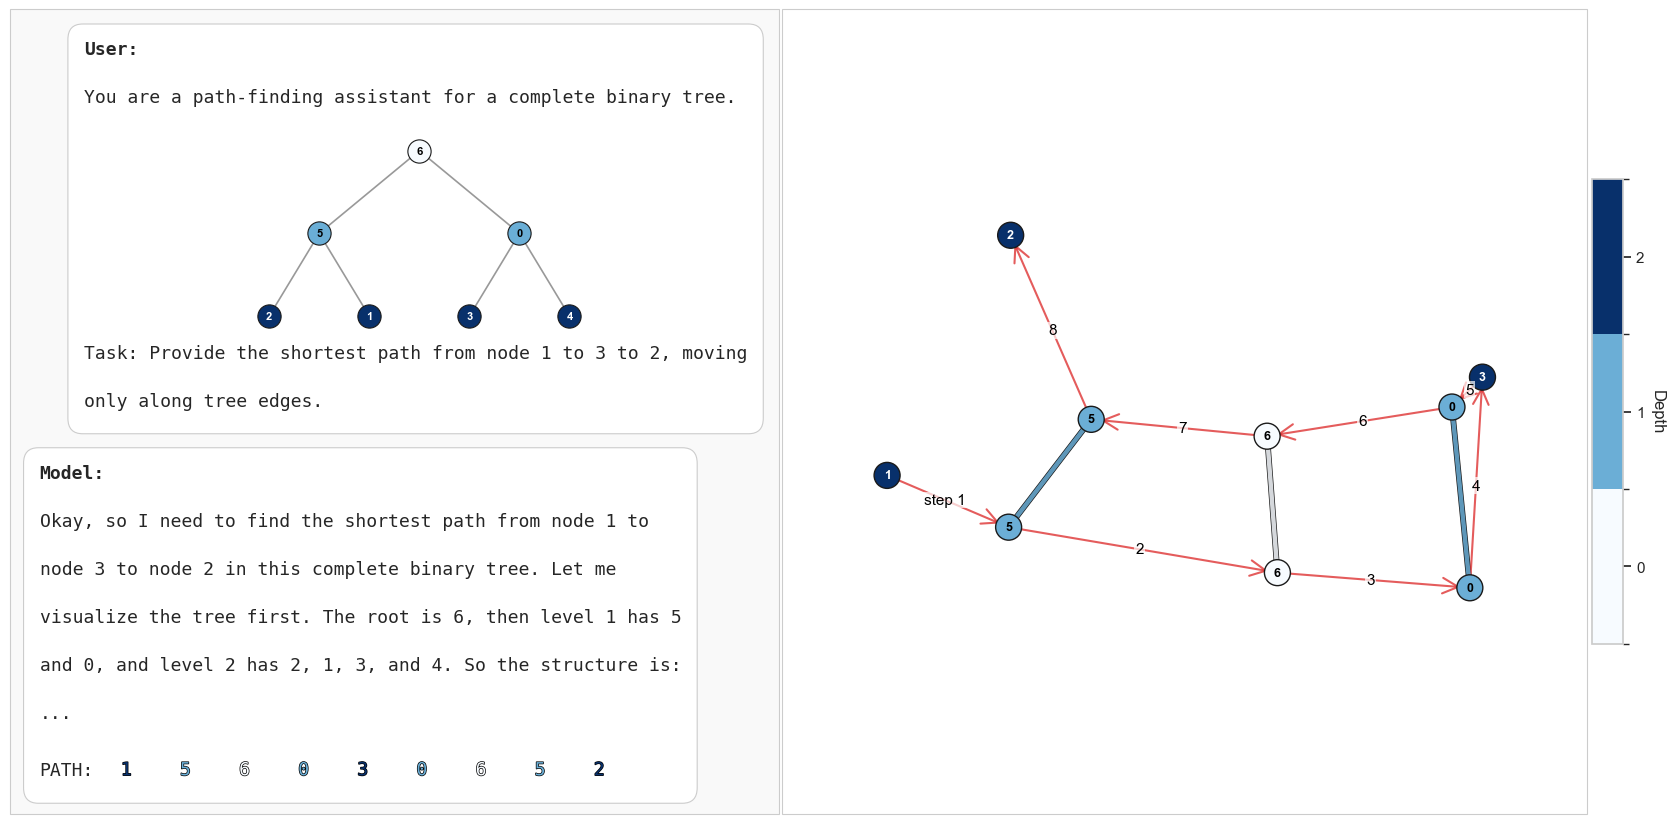

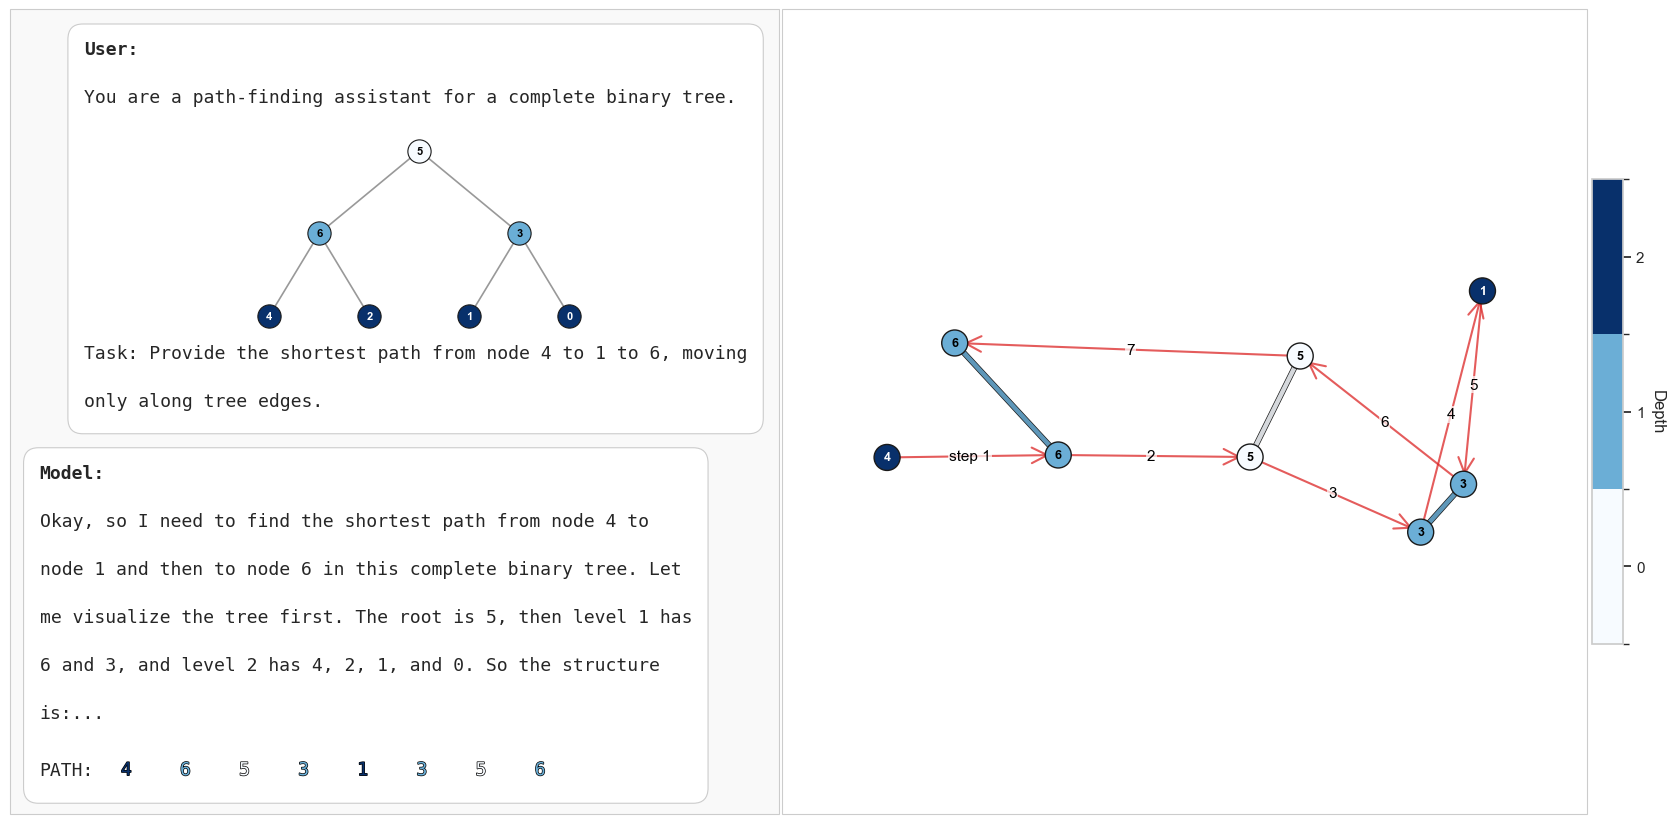

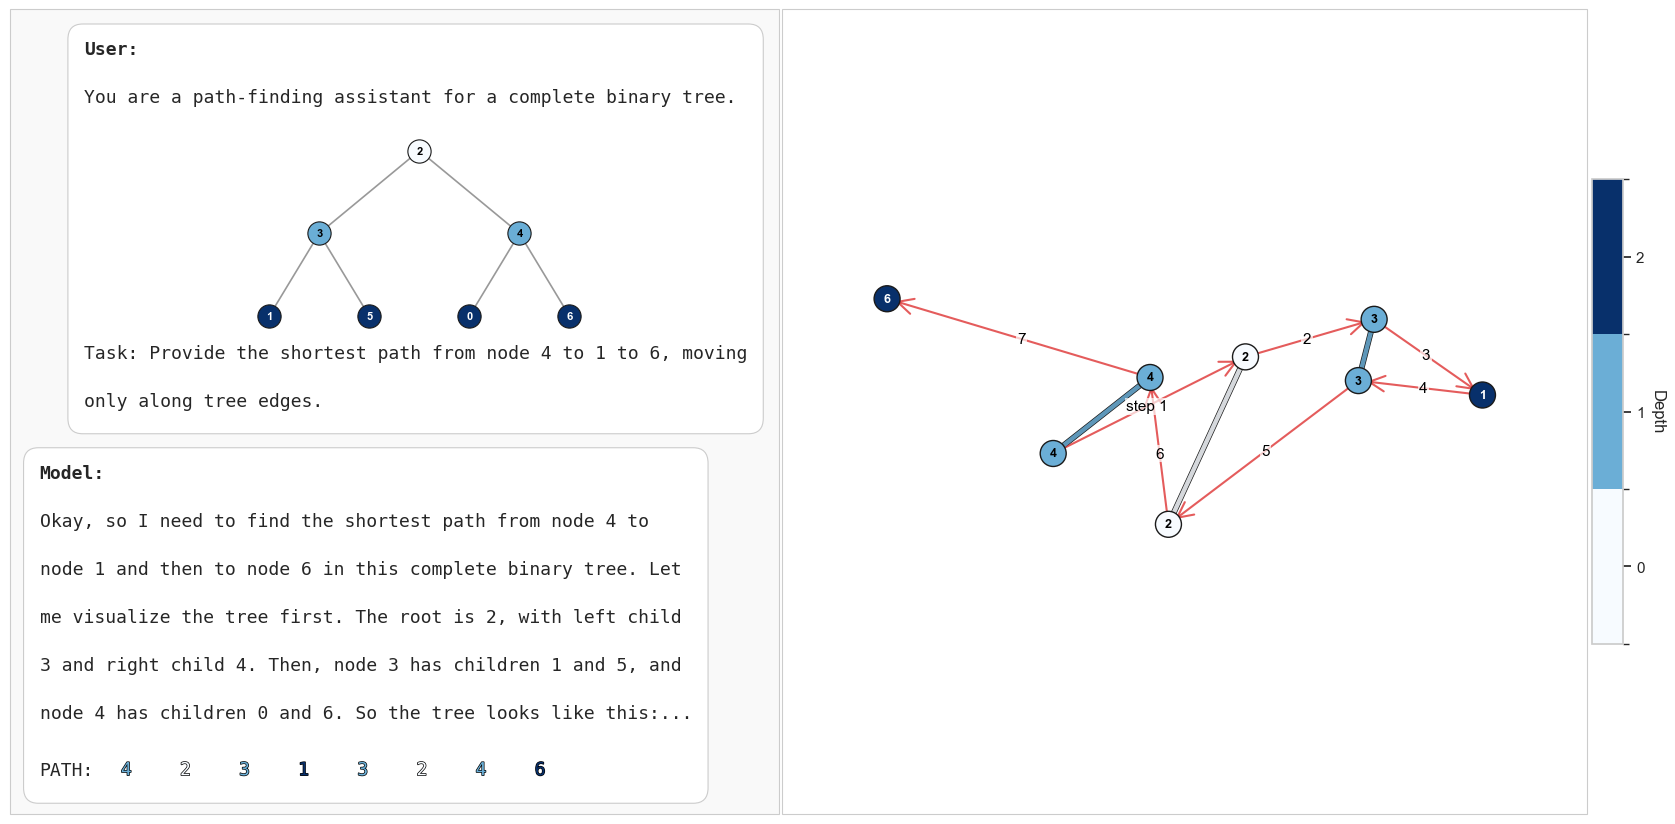

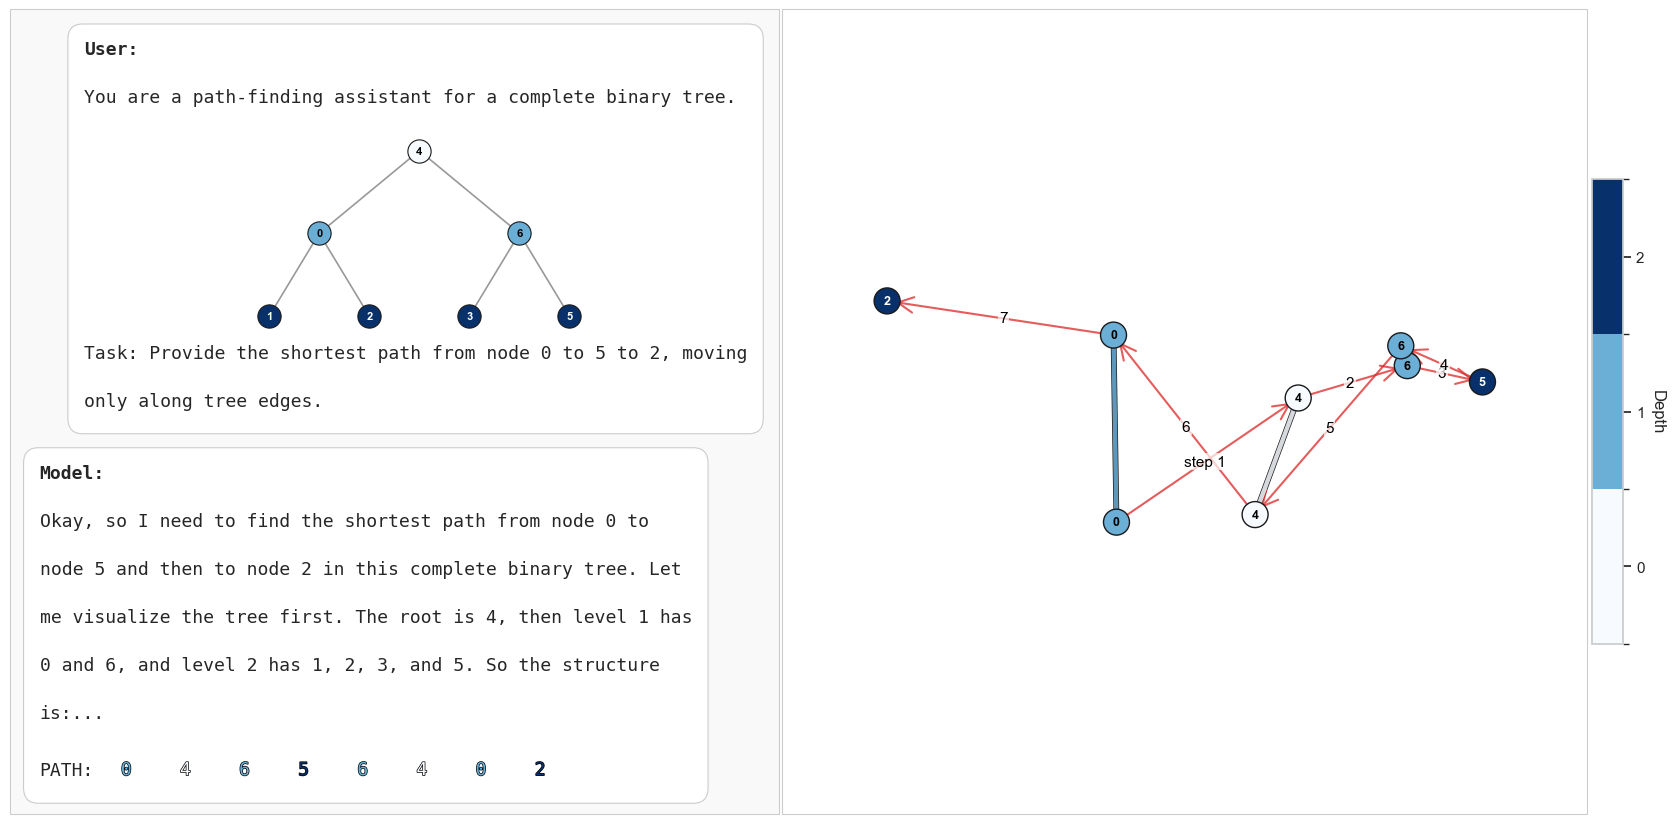

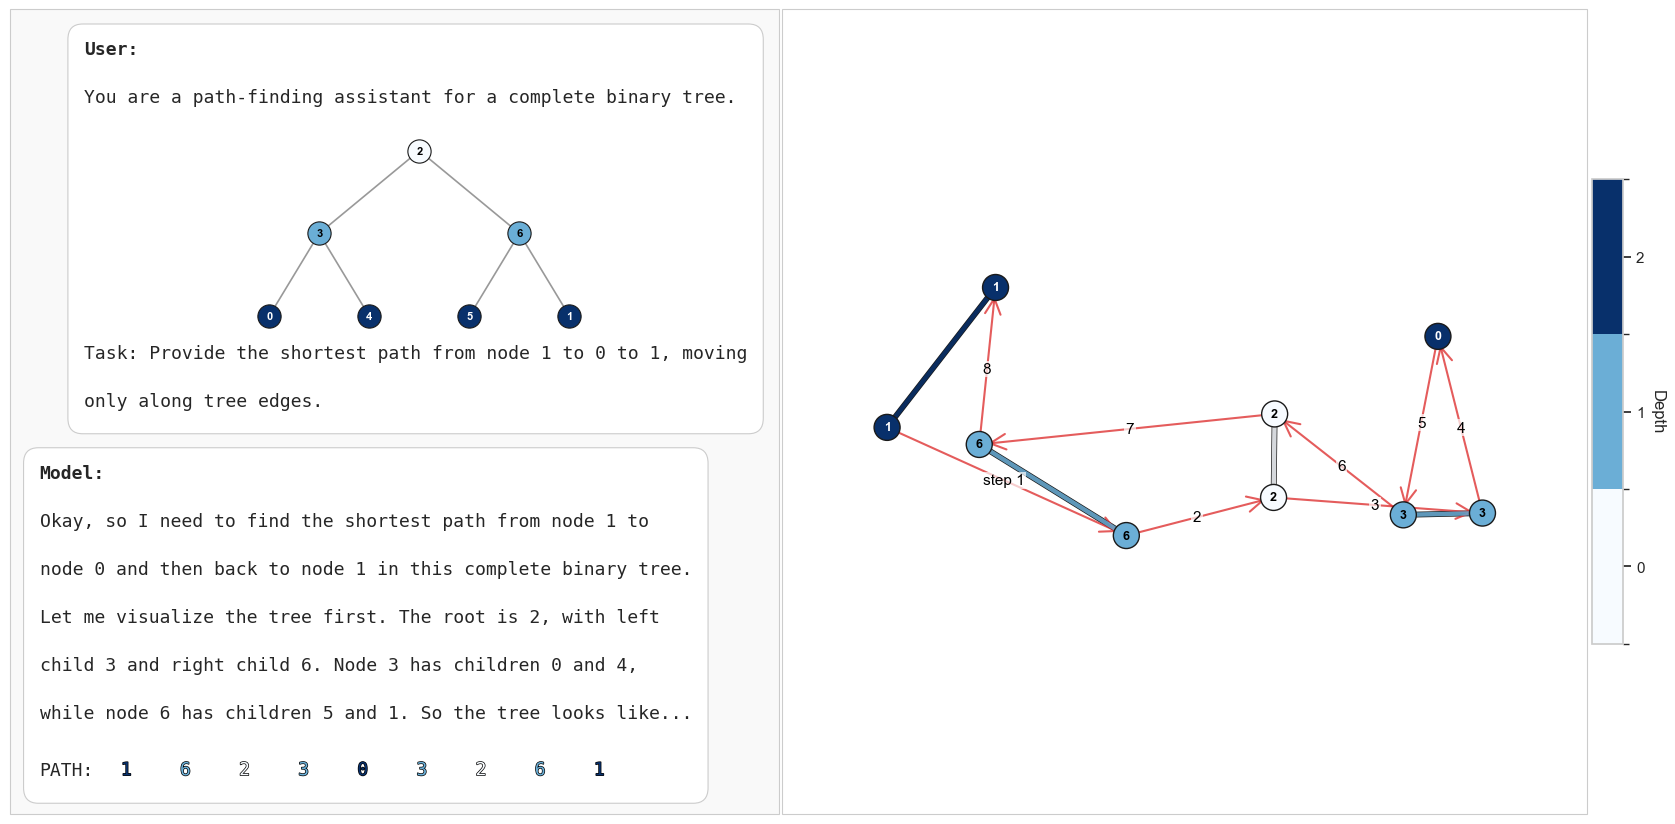

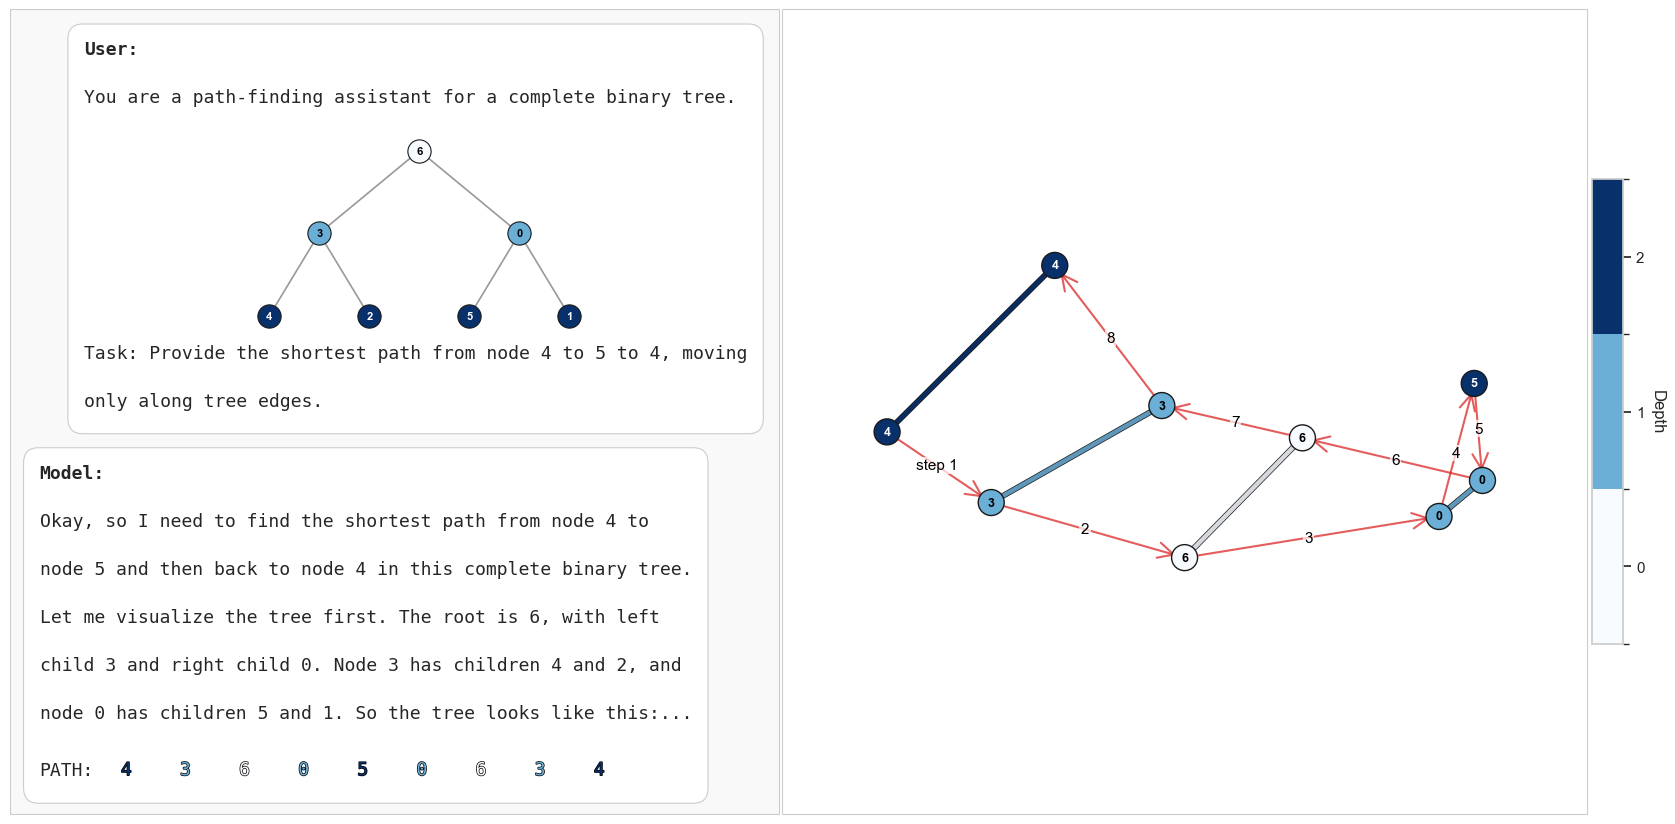

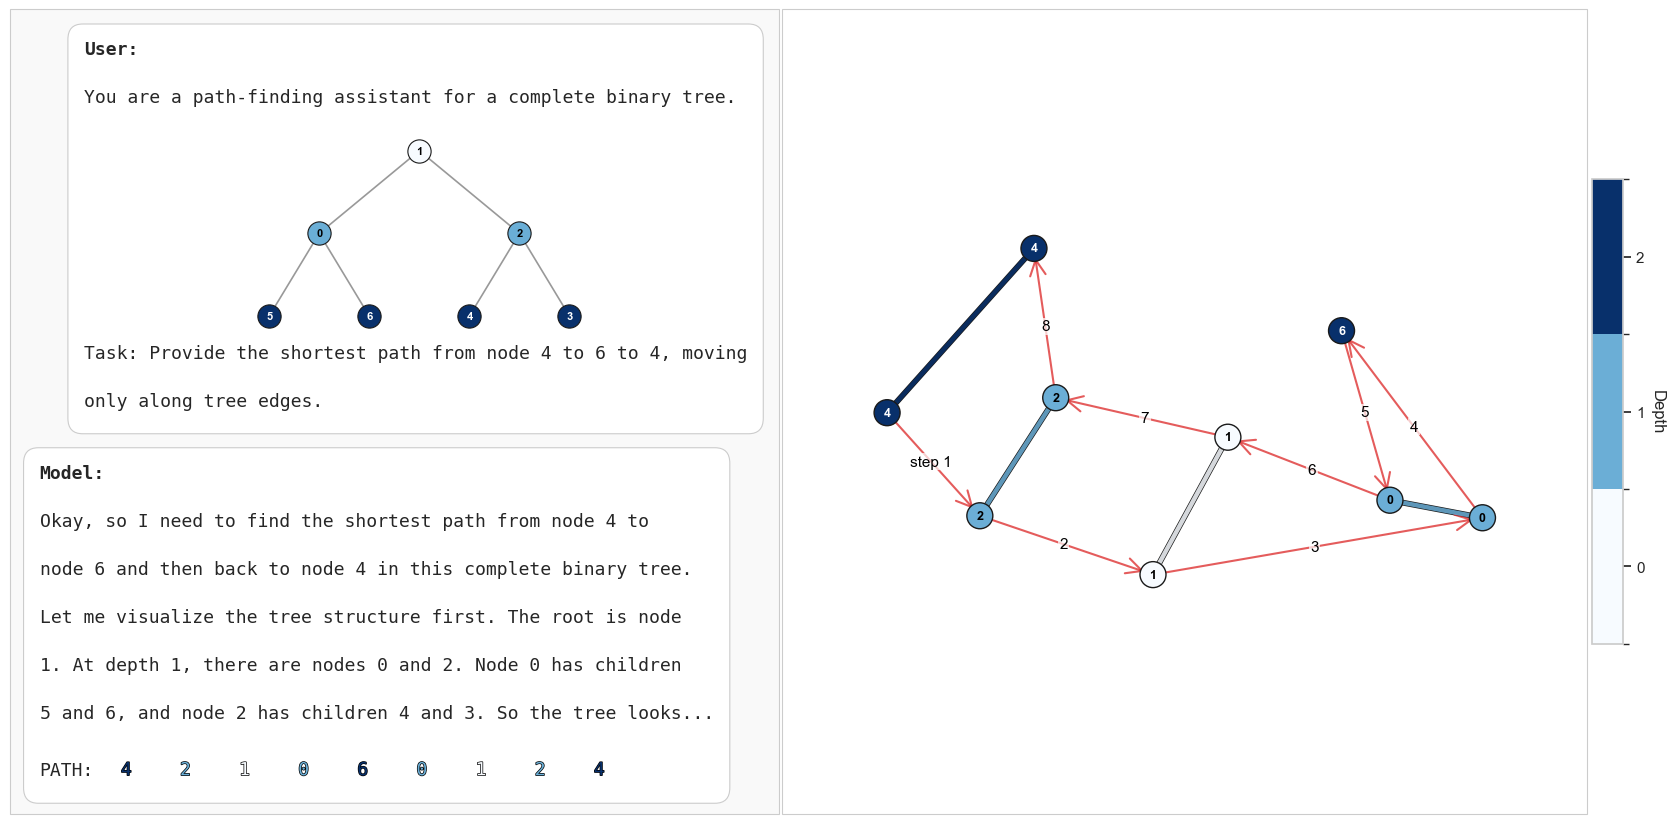

In [7]:
# Overlay N randomized test_exact examples on top of the test-only projection
from pathlib import Path
import json
import textwrap
import re
from matplotlib.patches import Rectangle, FancyBboxPatch

NODE_MARKER_SIZE = 280

EMBEDDINGS_PATH = _locate_embeddings(meta, RESULTS_PATH, PROJECT_ROOT)
RESPONSES_PATH = PROJECT_ROOT / f"cutter/data/{DATASET_TAG}/models/{MODEL_TAG}/responses.jsonl"

if not EMBEDDINGS_PATH.exists():
    raise FileNotFoundError(f"Embeddings cache not found: {EMBEDDINGS_PATH}")

embedding_records = np.load(EMBEDDINGS_PATH, allow_pickle=True)["embeddings"]


def project_embeddings(arr: np.ndarray, B: np.ndarray, geometry: str, info: Dict[str, Any], res: dict) -> np.ndarray:
    features = _pca_transform(arr.astype(np.float32), res)
    proj = features @ B
    if geometry == "hyperbolic":
        proj = transform_probe_space(proj, info)
    return proj


def collect_test_exact_ids(layer: int, depth_filter: int = DEPTH_FILTER, min_path_len: int = MIN_PATH_LEN):
    data = encodings[layer]
    example_ids = np.asarray(data.get("example_ids", []))
    if example_ids.size == 0:
        raise ValueError("Encodings missing example_ids; cannot map to embeddings")
    train_idx = set(data.get("train_idx", []))
    splits = np.array(["train" if i in train_idx else "test" for i in range(len(example_ids))])
    per_example_split = {}
    for idx, ex_id in enumerate(example_ids):
        per_example_split.setdefault(ex_id, splits[idx])
    test_ids = {ex for ex, sp in per_example_split.items() if sp == "test"}

    exact_ids = set()
    depth_ok = set()
    path_len_ok = set()
    with open(RESPONSES_PATH) as f:
        for line in f:
            rec = json.loads(line)
            ex_id = rec.get("example_id")
            if rec.get("depth") == depth_filter:
                depth_ok.add(ex_id)
            if rec.get("exact_match"):
                exact_ids.add(ex_id)
            parsed_path = rec.get("parsed_path") or rec.get("path")
            if parsed_path and len(parsed_path) >= min_path_len:
                path_len_ok.add(ex_id)

    available_ids = {rec["example_id"] for rec in embedding_records}
    candidates = sorted(test_ids & exact_ids & available_ids & depth_ok & path_len_ok)
    if not candidates:
        raise ValueError("No overlapping test_exact examples between encodings, responses, and embeddings.npz after filters")
    return candidates


def _wrap_lines(lines, width=65):
    wrapped = []
    for line in lines:
        # Preserve tree ASCII lines without wrapping
        if line.strip() and all(ch.isdigit() or ch.isspace() for ch in line):
            wrapped.append(line)
            continue
        wrapped.extend(textwrap.wrap(line, width=width) or [""])
    return wrapped


def _abridge_text_blocks(prompt: str, model_raw: str, max_prompt_lines: int = 6, max_model_lines: int = 5, width: int = 65, model_width: int = 60):
    """Return wrapped prompt/model snippets. PATH handled separately."""
    prompt_lines = prompt.splitlines()
    # Trim prompt before "Guidelines" if present
    if "Guidelines:" in prompt_lines:
        prompt_lines = prompt_lines[:prompt_lines.index("Guidelines:")]

    tree_graph_idx = prompt_lines.index("Tree Graph:") if "Tree Graph:" in prompt_lines else None
    task_idx = None
    if tree_graph_idx is not None:
        depth_idxs = [i for i, ln in enumerate(prompt_lines[:tree_graph_idx]) if ln.strip().startswith("Tree depth:")]
        if depth_idxs:
            depth_idx = depth_idxs[0]
            prompt_lines = prompt_lines[:depth_idx] + prompt_lines[tree_graph_idx:]
    task_idxs = [i for i, ln in enumerate(prompt_lines) if ln.strip().startswith("Task:")]
    if task_idxs:
        task_idx = task_idxs[0]

    prompt_snip = []
    # Preamble: first few lines to capture task spec header
    preamble = prompt_lines[:3]
    prompt_snip.extend(preamble)

    # Deduplicate while preserving order and cap length
    seen = set()
    deduped = []
    for ln in prompt_snip:
        if ln not in seen:
            deduped.append(ln)
            seen.add(ln)
    prompt_snip = deduped[: max_prompt_lines + 2]

    task_lines = []
    if task_idx is not None:
        task_lines.append(prompt_lines[task_idx])
        if task_idx + 1 < len(prompt_lines):
            task_lines.append(prompt_lines[task_idx + 1])
    # Do not append ellipsis; keep as-is
    prompt_snip = [ln for ln in prompt_snip if ln.strip() != "Tree Graph:" and not ln.strip().isdigit()]
    prompt_snip = _wrap_lines(prompt_snip, width=width)
    task_lines = _wrap_lines(task_lines, width=width)

    model_lines = model_raw.splitlines()
    # Wrap and keep multiple lines of CoT in the subplot
    wrapped_model = _wrap_lines(model_lines, width=model_width)
    model_snip = wrapped_model[:max_model_lines]
    if wrapped_model and len(wrapped_model) > max_model_lines:
        model_snip[-1] = model_snip[-1] + "..."
    elif model_snip:
        model_snip[-1] = model_snip[-1] + "..."
    else:
        model_snip = []

    return prompt_snip, task_lines, model_snip


def _parse_tree_ascii(tree_ascii: str | None):
    if not tree_ascii:
        return [], []
    lines = [ln.rstrip("\n") for ln in tree_ascii.splitlines() if ln.strip()]
    nodes = []
    for row_idx, line in enumerate(lines):
        for match in re.finditer(r"\d+", line):
            label = int(match.group())
            col = (match.start() + match.end() - 1) / 2.0
            nodes.append({"label": label, "row": row_idx, "col": col})
    if not nodes:
        return [], []

    cols = [n["col"] for n in nodes]
    min_col, max_col = min(cols), max(cols)
    max_row = max(n["row"] for n in nodes)

    for n in nodes:
        n["x"] = 0.5 if max_col == min_col else (n["col"] - min_col) / (max_col - min_col)
        n["y"] = 1.0 if max_row == 0 else 1.0 - (n["row"] / max_row)

    nodes_by_row = {}
    for n in nodes:
        nodes_by_row.setdefault(n["row"], []).append(n)

    edges = []
    for row_idx in range(1, max_row + 1):
        parents = nodes_by_row.get(row_idx - 1, [])
        if not parents:
            continue
        for n in nodes_by_row.get(row_idx, []):
            parent = min(parents, key=lambda p: abs(p["col"] - n["col"]))
            edges.append((parent, n))

    return nodes, edges


def plot_test_with_example(layer: int, example_id: int, prompt: str, model_raw: str, path_line: str, tree_ascii: str | None = None, label_mapping: list[int] | None = None, parsed_path: list[int] | None = None):
    data = encodings[layer]
    res = results[layer]
    X = data["X"]
    depths = data["depth"]
    example_ids = np.asarray(data.get("example_ids", []))
    node_ids = np.asarray(data.get("node_ids", []))
    label_mapping = label_mapping or []
    label_lookup = {idx: int(label) for idx, label in enumerate(label_mapping)} if label_mapping else {}
    inverse_label = {int(label): idx for idx, label in enumerate(label_mapping)} if label_mapping else {}
    train_idx = set(data.get("train_idx", []))
    splits = np.array(["train" if i in train_idx else "test" for i in range(len(depths))])
    color_values, cmap, norm, cbar_label, tick_locs, tick_labels = prepare_colorcode(COLORCODE, node_ids, depths, example_ids)
    B = _resolve_probe_projection(res)
    if B is None:
        raise ValueError(f"No projection found in results for layer {layer}")
    info = {
        "geometry": res.get("geometry", meta.get("fit_geometry", "euclidean")),
        "center": res.get("center"),
        "curvature": res.get("curvature"),
        "normalized_tree": res.get("normalized_tree", meta.get("normalize_tree", False)),
    }
    geometry = info.get("geometry", meta.get("fit_geometry", "euclidean"))

    Z = project_embeddings(X, B, geometry, info, res)
    Z = _project_to_2d(Z)

    mask_example = example_ids == example_id
    Z_example = Z[mask_example]
    depths_example = depths[mask_example]
    colors_example = color_values[mask_example]
    labels_example = np.array([label_lookup.get(int(nid), int(nid)) for nid in node_ids[mask_example]])
    node_ids_example = node_ids[mask_example]
    
    # Parse PATH sequence for drawing lines
    path_node_ids = []
    path_tokens = []
    if parsed_path:
        path_tokens = [str(tok) for tok in parsed_path]
    elif path_line and path_line.upper().startswith("PATH:"):
        path_tokens = path_line.split()[1:]
    for tok in path_tokens:
        try:
            label_val = int(tok)
            canonical_id = inverse_label.get(label_val, label_val)
            path_node_ids.append(int(canonical_id))
        except Exception:
            continue
    
    # Use path order to preserve repeated nodes; fall back to sequential matching.
    path_indices = []
    if path_node_ids:
        path_node_ids = [int(nid) for nid in path_node_ids]
        node_ids_list = [int(nid) for nid in node_ids_example]
        if node_ids_list[: len(path_node_ids)] == path_node_ids:
            path_indices = list(range(len(path_node_ids)))
        else:
            ptr = 0
            for idx, nid in enumerate(node_ids_list):
                if ptr < len(path_node_ids) and nid == path_node_ids[ptr]:
                    path_indices.append(idx)
                    ptr += 1
    
    # Rotate embeddings to make depth levels as horizontally level as possible
    overall_center = Z_example.mean(axis=0)
    centered = Z_example - overall_center
    unique_depths = np.unique(depths_example)

    def _leveling_cost(theta: float) -> float:
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        R = np.array([[cos_t, -sin_t], [sin_t, cos_t]])
        rotated = centered @ R.T
        cost = 0.0
        for d in unique_depths:
            mask = depths_example == d
            if mask.any():
                y = rotated[mask, 1]
                y_mean = float(y.mean())
                diff = y - y_mean
                cost += float((diff * diff).sum())
        return cost

    # Coarse grid search over [-pi/2, pi/2] (rotation only)
    angles = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 361)
    costs = np.array([_leveling_cost(theta) for theta in angles])
    best_theta = float(angles[int(costs.argmin())])

    cos_a, sin_a = np.cos(best_theta), np.sin(best_theta)
    R = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    Z_example = centered @ R.T + overall_center

    # Invert y-axis so lowest-depth nodes end up near the top
    Z_example[:, 1] = 2 * overall_center[1] - Z_example[:, 1]

    fig, axes = plt.subplots(1, 2, figsize=(17, 9), gridspec_kw={"width_ratios": [1, 1]})
    fig.subplots_adjust(wspace=0.01)

    # Left: text panel with larger font and inline PATH highlighting
    for spine in axes[0].spines.values():
        spine.set_visible(False)
    # We'll draw the grey panel background in figure-coordinates so it can extend
    # beyond the axes bounds to match the outer panel outline.
    axes[0].set_facecolor("none")
    axes[0].patch.set_alpha(0.0)
    # Keep axes limits fixed; panel outline/background drawn later in figure-coordinates
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].set_aspect("auto", adjustable="box")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Right: match left panel outline styling
    # (We draw the panel outlines later in figure-coordinates so both panels match.)
    for spine in axes[1].spines.values():
        spine.set_visible(False)

    prompt_snip, task_lines, model_snip = _abridge_text_blocks(prompt, model_raw, model_width=60)
    y = 0.98
    line_h = 0.062
    user_texts = []
    model_texts = []
    user_text_x = 0.08
    model_text_x = 0.02
    depth_cmap = plt.cm.Blues

    t = axes[0].text(user_text_x, y, "User:", fontsize=13, fontweight="bold", family="monospace", va="top", ha="left")
    user_texts.append(t)
    y -= line_h
    for ln in prompt_snip:
        t = axes[0].text(user_text_x, y, ln, fontsize=13, family="monospace", va="top", ha="left")
        user_texts.append(t)
        y -= line_h

    tree_ax = None
    if tree_ascii:
        tree_nodes, tree_edges = _parse_tree_ascii(tree_ascii)
        if tree_nodes:
            tree_rows = max(n["row"] for n in tree_nodes) + 1
            tree_h = min(0.34, line_h * max(4, tree_rows) * 1.0)
            tree_w = 0.55
            y -= line_h * 0.15
            tree_y1 = y + line_h * 0.12
            tree_y0 = tree_y1 - tree_h
            tree_x0 = 0.5 - tree_w / 2
            tree_ax = axes[0].inset_axes([tree_x0, tree_y0, tree_w, tree_h], transform=axes[0].transAxes)
            tree_ax.set_axis_off()

            all_xs = [n["x"] for n in tree_nodes]
            target_center = (min(all_xs) + max(all_xs)) / 2
            shifted_x = [n["x"] - target_center + 0.5 for n in tree_nodes]
            min_x, max_x = min(shifted_x), max(shifted_x)
            if max_x - min_x > 0:
                scale = 1.0 / (max_x - min_x)
                for n, sx in zip(tree_nodes, shifted_x):
                    n["x"] = (sx - min_x) * scale
            else:
                for n in tree_nodes:
                    n["x"] = 0.5

            root_nodes = [n for n in tree_nodes if n["row"] == 0]
            child_nodes = [n for n in tree_nodes if n["row"] > 0]
            if root_nodes and child_nodes:
                child_xs = [n["x"] for n in child_nodes]
                center_x = (min(child_xs) + max(child_xs)) / 2
                for n in root_nodes:
                    n["x"] = center_x

            for parent, child in tree_edges:
                tree_ax.plot(
                    [parent["x"], child["x"]],
                    [parent["y"], child["y"]],
                    color="#999999",
                    lw=1.2,
                    zorder=0,
                )

            canonical_labels = [inverse_label.get(int(n["label"]), int(n["label"])) for n in tree_nodes]
            depth_vals = [int(np.floor(np.log2(lbl + 1))) for lbl in canonical_labels]
            min_depth = min(depth_vals)
            max_depth = max(depth_vals)
            if max_depth == min_depth:
                max_depth = min_depth + 1
            depth_norm_tree = Normalize(vmin=min_depth, vmax=max_depth)

            for n, d in zip(tree_nodes, depth_vals):
                color = depth_cmap(depth_norm_tree(d))
                tree_ax.scatter(
                    n["x"],
                    n["y"],
                    s=NODE_MARKER_SIZE,
                    c=[color],
                    edgecolors="k",
                    linewidths=0.8,
                    zorder=2,
                )
                text_color = "white" if max_depth == 2 and d == max_depth else "black"
                tree_ax.text(
                    n["x"],
                    n["y"],
                    str(n["label"]),
                    fontsize=8,
                    weight="bold",
                    color=text_color,
                    ha="center",
                    va="center",
                    zorder=3,
                )

            tree_ax.set_xlim(-0.08, 1.08)
            tree_ax.set_ylim(-0.08, 1.08)
            y = tree_y0 - line_h * 0.3

    for ln in task_lines:
        t = axes[0].text(user_text_x, y, ln, fontsize=13, family="monospace", va="top", ha="left")
        user_texts.append(t)
        y -= line_h

    y -= line_h * 0.5
    t = axes[0].text(model_text_x, y, "Model:", fontsize=13, fontweight="bold", family="monospace", va="top", ha="left")
    model_texts.append(t)
    y -= line_h
    for ln in model_snip:
        t = axes[0].text(model_text_x, y, ln, fontsize=13, family="monospace", va="top", ha="left")
        model_texts.append(t)
        y -= line_h

    # PATH line with inline colored tokens (inside Model bubble)
    depth_norm = Normalize(vmin=depths_example.min(), vmax=depths_example.max())
    if path_tokens:
        y -= line_h * 0.2
        t = axes[0].text(model_text_x, y, "PATH:", fontsize=13, family="monospace", va="top", ha="left")
        model_texts.append(t)
        x_offset = model_text_x + 0.11
        for tok in path_tokens:
            try:
                label_val = int(tok)
                canonical_id = inverse_label.get(label_val, label_val)
                node_depth = int(np.floor(np.log2(canonical_id + 1)))
            except Exception:
                node_depth = depths_example.min()
            color = depth_cmap(depth_norm(node_depth))
            # Add black outline to PATH tokens while keeping color-coding
            path_effect = [patheffects.withStroke(linewidth=1.0, foreground="black")]
            t = axes[0].text(
                x_offset,
                y,
                tok,
                fontsize=13,
                weight="light",
                family="monospace",
                va="top",
                ha="left",
                color=color,
                path_effects=path_effect,
            )
            model_texts.append(t)
            x_offset += 0.06 * max(len(tok), 1) + 0.02
            if x_offset > 0.96:
                y -= line_h
                x_offset = 0.11
        y -= line_h * 0.6

    # Right: projection plot - example only
    # Connect multiple embeddings of the same node with a clearer line
    for node_id in np.unique(node_ids_example):
        idxs = np.where(node_ids_example == node_id)[0]
        if idxs.size > 1:
            coords = Z_example[idxs]
            line_color = cmap(norm(colors_example[idxs[0]]))
            axes[1].plot(
                coords[:, 0],
                coords[:, 1],
                linestyle="-",
                color="black",
                alpha=0.9,
                lw=4.2,
                zorder=0,
            )
            axes[1].plot(
                coords[:, 0],
                coords[:, 1],
                linestyle="-",
                color=line_color,
                alpha=0.85,
                lw=3.2,
                zorder=1,
            )

    # Draw arrows between consecutive nodes in PATH sequence first (behind points)
    if path_node_ids and len(path_indices) > 1:
        # Draw arrows between consecutive nodes (pointing from left to right in path)
        # Estimate node radius based on scatter size (s=NODE_MARKER_SIZE) - approximate radius in data coordinates
        # Use a small fraction of the axis range to estimate node radius
        x_range = Z_example[:, 0].max() - Z_example[:, 0].min()
        y_range = Z_example[:, 1].max() - Z_example[:, 1].min()
        avg_range = (x_range + y_range) / 2
        node_radius_estimate = avg_range * 0.02  # Approximate node radius
        arrow_color = "#dc2626"

        for i in range(len(path_indices) - 1):
            idx1, idx2 = path_indices[i], path_indices[i + 1]
            x1, y1 = Z_example[idx1, 0], Z_example[idx1, 1]
            x2, y2 = Z_example[idx2, 0], Z_example[idx2, 1]

            # Calculate direction vector and position arrow end to touch node edge
            dx = x2 - x1
            dy = y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            if dist > 0:
                # Position arrow end at the edge of the target node circle (extend slightly more)
                shrink_factor = 1.0 - (node_radius_estimate * 0.7) / dist
                x2_adj = x1 + dx * shrink_factor
                y2_adj = y1 + dy * shrink_factor
            else:
                x2_adj, y2_adj = x2, y2

            axes[1].annotate(
                "",
                xy=(x2_adj, y2_adj),
                xytext=(x1, y1),
                arrowprops=dict(
                    arrowstyle="->",
                    color=arrow_color,
                    lw=1.5,
                    alpha=0.75,
                    mutation_scale=28,
                ),
                zorder=0,
            )
            label_x = (x1 + x2_adj) / 2
            label_y = (y1 + y2_adj) / 2
            step_label = "step 1" if i == 0 else f"{i + 1}"
            axes[1].text(
                label_x,
                label_y,
                step_label,
                color="black",
                fontsize=11,
                ha="center",
                va="center",
                zorder=2,
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1.0),
            )
    
    right_node_size = NODE_MARKER_SIZE * 1.25
    scatter = axes[1].scatter(
        Z_example[:, 0],
        Z_example[:, 1],
        c=colors_example,
        cmap=cmap,
        norm=norm,
        edgecolors="k",
        s=right_node_size,
        marker="o",
        zorder=1
    )
    
    # Add node labels
    for coords, label, depth in zip(Z_example, labels_example, depths_example):
        x, y = coords[:2]
        text_color = "white" if int(depth) == 2 else "black"
        axes[1].text(
            x,
            y,
            str(label),
            fontsize=9,
            weight="bold",
            color=text_color,
            ha="center",
            va="center",
        )

    # Set axis limits based on example embeddings with padding
    x_min, x_max = Z_example[:, 0].min(), Z_example[:, 0].max()
    y_min, y_max = Z_example[:, 1].min(), Z_example[:, 1].max()
    
    # Calculate ranges and ensure square aspect ratio
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    
    # Center the smaller range and add padding
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    padding = max_range * 0.15
    
    axes[1].set_xlim(x_center - max_range / 2 - padding, x_center + max_range / 2 + padding)
    axes[1].set_ylim(y_center - max_range / 2 - padding, y_center + max_range / 2 + padding)

    # Colorbar is added later (outside the right panel outline).
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Keep the right plot square; we'll set the axes boxes manually below.
    axes[1].set_aspect("equal", adjustable="box")

    # Manual layout
    # - Left panel width: computed from rendered text extents (tight wrap)
    # - Colorbar: dedicated axes, entirely outside the right panel
    bottom, top = 0.07, 0.93
    left_margin, right_margin = 0.04, 0.02
    inter_panel = 0.02
    cb_pad = 0.012
    cb_w = 0.018
    H = top - bottom

    # Right panel: physically square box
    fig_w, fig_h = fig.get_size_inches()
    right_w = H * (fig_h / fig_w)

    cax_x0 = 1.0 - right_margin - cb_w
    right_x1 = cax_x0 - cb_pad
    right_x0 = right_x1 - right_w

    # Measure required left width from the text artists
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    fig_px_w = fig.bbox.width

    req_left_px = 0.0
    for t in axes[0].texts:
        try:
            bb = t.get_window_extent(renderer=renderer)
        except Exception:
            continue
        x_start = float(t.get_position()[0])
        denom = max(1e-6, 1.0 - x_start)
        req_left_px = max(req_left_px, bb.width / denom)

    # Add a little padding to the measured width
    req_left_w = (req_left_px + 30.0) / fig_px_w
    max_left_w = max(0.1, right_x0 - inter_panel - left_margin)
    left_w = min(req_left_w, max_left_w)

    axes[0].set_position([left_margin, bottom, left_w, H])
    axes[1].set_position([right_x0, bottom, right_w, H])

    cb_h = H * 0.6
    cb_y0 = bottom + (H - cb_h) / 2
    cax = fig.add_axes([cax_x0, cb_y0, cb_w, cb_h])
    cbar = fig.colorbar(scatter, cax=cax)
    cbar.set_label(cbar_label, rotation=270, labelpad=15)
    if tick_locs is not None:
        cbar.set_ticks(tick_locs)
        cbar.set_ticklabels(tick_labels)
    if hasattr(cbar, "solids"):
        cbar.solids.set_alpha(1)

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    def _bubble_from_artists(artists, pad_px: float = 8.0, extra_bottom_px: float = 0.0, x_offset: float = 0.0):
        bbs = []
        for artist in artists:
            try:
                bbs.append(artist.get_window_extent(renderer=renderer))
            except Exception:
                continue
        if not bbs:
            return
        x0 = min(bb.x0 for bb in bbs) - pad_px
        y0 = min(bb.y0 for bb in bbs) - pad_px - extra_bottom_px
        x1 = max(bb.x1 for bb in bbs) + pad_px
        y1 = max(bb.y1 for bb in bbs) + pad_px
        (ax_x0, ax_y0) = axes[0].transAxes.inverted().transform((x0, y0))
        (ax_x1, ax_y1) = axes[0].transAxes.inverted().transform((x1, y1))
        ax_x0 += x_offset
        ax_x1 += x_offset
        bubble = FancyBboxPatch(
            (ax_x0, ax_y0),
            ax_x1 - ax_x0,
            ax_y1 - ax_y0,
            boxstyle="round,pad=0.0,rounding_size=0.02",
            linewidth=0.8,
            edgecolor="#cccccc",
            facecolor="white",
            alpha=1.0,
            transform=axes[0].transAxes,
            clip_on=False,
            zorder=0.5,
        )
        axes[0].add_patch(bubble)

    user_artists = user_texts + ([tree_ax] if tree_ax is not None else [])
    _bubble_from_artists(user_artists, pad_px=16.0, extra_bottom_px=8.0)
    _bubble_from_artists(model_texts, pad_px=16.0, extra_bottom_px=8.0)

    # Panel outlines/background (now based on final axes positions)
    pad_frac = 0.02

    def _panel_from_ax(ax, *, fill: bool):
        pos = ax.get_position().frozen()
        x0 = pos.x0 - pad_frac * pos.width
        y0 = pos.y0 - pad_frac * pos.height
        w = pos.width * (1 + 2 * pad_frac)
        h = pos.height * (1 + 2 * pad_frac)

        if fill:
            bg = Rectangle(
                (x0, y0),
                w,
                h,
                linewidth=0.0,
                edgecolor="none",
                facecolor="#f5f5f5",
                alpha=0.6,
                transform=fig.transFigure,
                clip_on=False,
                zorder=-5,
            )
            fig.add_artist(bg)

        outline = Rectangle(
            (x0, y0),
            w,
            h,
            linewidth=0.8,
            edgecolor="#cccccc",
            facecolor="none",
            alpha=1.0,
            transform=fig.transFigure,
            clip_on=False,
            zorder=10,
        )
        fig.add_artist(outline)

    _panel_from_ax(axes[0], fill=True)
    _panel_from_ax(axes[1], fill=False)

    plt.show()


def extract_tree_and_path(example_id: int):
    model_path_line = None
    tree_ascii = None
    prompt = ""
    model_raw = ""
    label_mapping = []
    parsed_path = []
    with open(RESPONSES_PATH) as f:
        for line in f:
            rec = json.loads(line)
            if rec.get("example_id") == example_id:
                model_raw = rec.get("model_raw", "")
                for ln in model_raw.splitlines()[::-1]:
                    stripped = ln.strip()
                    if stripped.upper().startswith("PATH:"):
                        model_path_line = stripped
                        break
                parsed_path = rec.get("parsed_path") or []
                if model_path_line is None and parsed_path:
                    model_path_line = "PATH: " + " ".join(str(x) for x in parsed_path)
                elif model_path_line is None and rec.get("parsed_text"):
                    model_path_line = f"PATH: {rec['parsed_text']}"
                prompt = rec.get("prompt", "")
                label_mapping = rec.get("label_mapping") or []
                if prompt:
                    lines = prompt.splitlines()
                    if "Tree Graph:" in lines:
                        start = lines.index("Tree Graph:") + 1
                        collected = []
                        for ln in lines[start:]:
                            if ln.strip() == "" and collected:
                                break
                            collected.append(ln)
                        tree_ascii = "\n".join(collected).strip()
                break
    return prompt, model_raw, tree_ascii, model_path_line, label_mapping, parsed_path


# Reuse the lowest-MSE selection from the 2x4 grid
for ex_id in chosen:
    prompt, model_raw, tree_ascii, model_path_line, label_mapping, parsed_path = extract_tree_and_path(ex_id)
    plot_test_with_example(LAYER, ex_id, prompt, model_raw, model_path_line, tree_ascii, label_mapping, parsed_path)